# Optimizing SR on Ideal Topography

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import params_ideal as params

from fun_ideal import calc_flood_height, generate_groups, calc_group_vol, calc_group_h, get_wall_heights
from ideal_damage import Damage
from topo_ideal import Topo

In [2]:
topo_file = "Input/ideal_topo_gp_points_1.csv"

storm_file = "../SurgeData/0-waterlevel_w.csv"
storm_file_c = "../SurgeData/0-waterlevel_c.csv"
div_data_file = "Input/ideal_div_data.csv"
time_file = "../SurgeData/0-time_w.csv"
time_file_c = "../SurgeData/0-time_c.csv"
damage_table_file = "Input/damage_table_combined.csv"

In [3]:
#surge = pd.read_csv(storm_file).to_numpy()
#surge_time = pd.read_csv(time_file).to_numpy()

surge = np.concatenate((pd.read_csv(storm_file).to_numpy(), pd.read_csv(storm_file_c).to_numpy()), axis=0)
surge_time = np.concatenate((pd.read_csv(time_file).to_numpy(), pd.read_csv(time_file_c).to_numpy()), axis=0)
damage_table = pd.read_csv(damage_table_file)


Topo = Topo(topo_file=topo_file)
Damage = Damage(damage_table_file)

In [4]:
# generate groups
#groups = generate_groups(Topo.div_data)

segment_l = 100
wall_height = np.zeros(Topo.shore_height.size)

# Infinite Water Travel
(Water level is assumed to reach equilibrium)

# Single Ensemble Uniform Allocation
Allocates same height across the topo (Note: might not make difference if on uniform topo)

In [5]:
params.travel_dist = 999

divs_allocate = list(range(18))
groups = generate_groups(Topo.div_data)

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 3
h_num = 100


wall_height[positions] = h_start

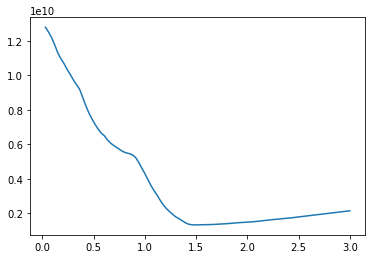

In [6]:
points = []
for h in np.linspace(h_start, h_end, num=h_num):
    wall_height[:] = 0
    wall_height[positions] = h

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_height * segment_l)
    cost_tot = cost_dmg + cost_wall
    
    if h != 0:
        points.append([h, cost_wall, cost_dmg, cost_tot, volume_div[0,0], volume_div[4,0], volume_div[0, 10], volume_div[4,10], volume_grouped[0,0], volume_grouped[4,0]])
    
df = pd.DataFrame(points)
#df.to_csv("Output/full_uniform_wall_opt.csv")
#print(df)
plt.figure()
plt.plot(df.iloc[:,0], df.iloc[:,3])

Plot minimum height of shore topography instead of wall height

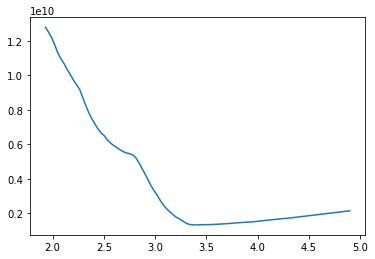

In [7]:
min_height = np.min(Topo.shore_height)
plt.figure()
plt.plot(df.iloc[:,0] + min_height, df.iloc[:,3])

# Single Ensemble Even Allocation
Allocates to even out topo

In [13]:
params.travel_dist = 999


groups = generate_groups(Topo.div_data)
        
h_max = 5
dh = 0.05


min_height = np.min(Topo.shore_height)
N = int(np.max(np.ceil((h_max - min_height)/dh), 0))

In [14]:
points = []
for n in range(N):
    height = min_height + n*dh

    pos, wall_heights = get_wall_heights(Topo, height) 

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_heights, pos)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    dmg_per_storm = np.sum(dmg, axis=1)
    dmg_per_div = np.sum(dmg, axis=0)
    dmg_tot = np.sum(dmg_per_div)
    cost_wall = np.sum(49212 * wall_heights * segment_l)
    cost_tot = dmg_tot + cost_wall
    
    if n != 0: 
        points.append([height, cost_wall, dmg_tot, cost_tot, *dmg_per_storm])
    
df = pd.DataFrame(points)
#df.to_csv("Output/full_even_wall_opt_2.csv")
#print(df)

Text(0, 0.5, 'Damage ($)')

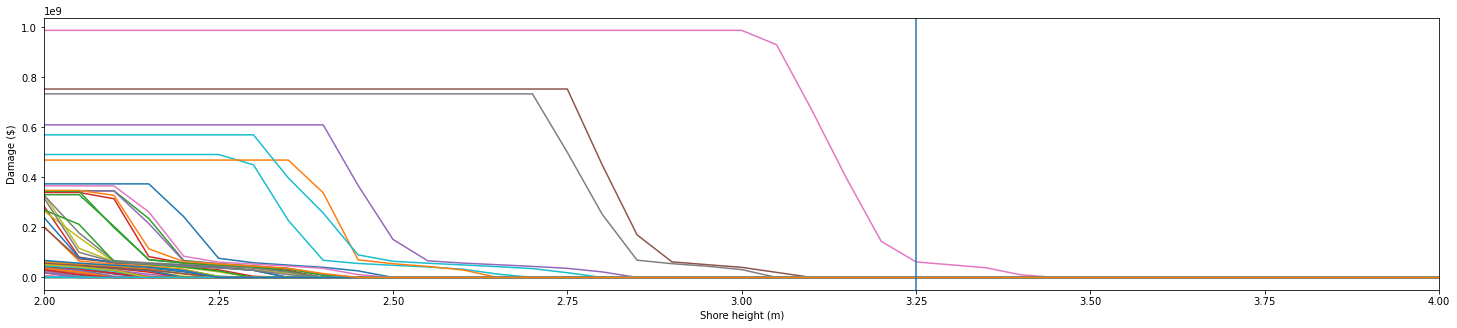

In [15]:
fig = plt.figure()
for d in range(dmg_per_storm.size):
    plt.plot(df.iloc[:,0], df.iloc[:,4+d])
fig.set_size_inches(25,5)
plt.xlim(2, 4)
# plt.ylim(0, 0.8*1e7)

opt_arg = np.argmin(df.iloc[:,3])
opt_cost_wall = df.iloc[:,1][opt_arg]
opt_height = df.iloc[:,0][opt_arg]
plt.axvline(x=opt_height)
plt.xlabel(r"Shore height (m)")
plt.ylabel(r"Damage ($)")

26
62028809.63513096


Text(0, 0.5, 'Damage cost ($)')

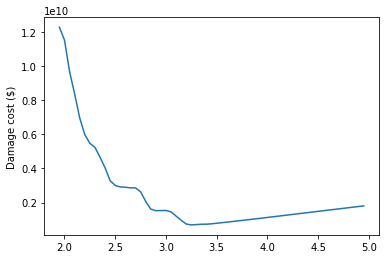

In [16]:
plt.figure()
plt.plot(df.iloc[:,0], df.iloc[:,3])
print(opt_arg)
print(df.iloc[:,2][opt_arg])
plt.ylabel(r"Damage cost ($)")

# Single Ensemble Even Allocation w. Avg Fitted Volume Func

In [17]:
def calc_group_h_fitted_avg(Topo, groups, volume_grouped, surge_peak):
    # HARDCODED, calculates volume in each division with volume function fitted to all divs, very rough 
    height_group = np.zeros(volume_grouped.shape)
    
    for div in range(height_group.shape[1]):
        vol = volume_grouped[:,div] / 18 # Ha
        height_group[:, div] = np.minimum(2.94116829e-03 * np.sqrt(vol) - 3.36575759e-07*vol, surge_peak)
    return height_group

params.travel_dist = 999


groups = generate_groups(Topo.div_data)
        
h_max = 5
dh = 0.01


min_height = np.min(Topo.shore_height)
N = int(np.max(np.ceil((h_max - min_height)/dh), 0))

In [18]:
points = []
for n in range(N):
    height = min_height + n*dh

    pos, wall_heights = get_wall_heights(Topo, height) 

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_heights, pos)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h_fitted_avg(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    dmg_all_divs = np.sum(dmg, axis=1)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_heights * segment_l)
    cost_tot = cost_dmg + cost_wall

    if n != 0:
        points.append([height, cost_wall, cost_dmg, cost_tot, height_grouped[4,1], *dmg_all_divs])
    
df = pd.DataFrame(points)
#%matplotlib notebook
# for d in range(dmg_all_divs.size):
#     plt.plot(df.iloc[:,1], df.iloc[:,4+d])

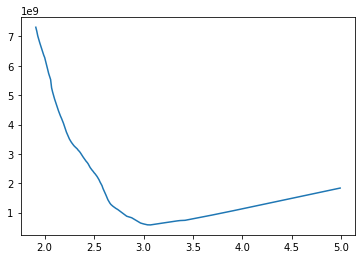

In [19]:
plt.plot(df.iloc[:,0], df.iloc[:,3])